In [4]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [5]:
# 1) Read your CSV
# Get the directory of the current script
base_dir = os.path.dirname(os.path.abspath('__file__'))
csv_path = os.path.join(base_dir, "./processed/combined_transactions.csv")

df = pd.read_csv(csv_path).sample(frac=1, random_state=42).reset_index(drop=True)

# 2) Feature engineering
#    - Create numeric columns: transaction_amount, day_of_week, hour_of_day, etc.
#    - Encode categorical features: category, description, etc.
#    - Example: df['isFraud'] is your label (1 for fraud, 0 for not fraud)

# Handle date columns
# if 'transaction_date' in df.columns:
#     df['year'] = pd.to_datetime(df['transaction_date']).dt.year
#     df['month'] = pd.to_datetime(df['transaction_date']).dt.month
#     df['day'] = pd.to_datetime(df['transaction_date']).dt.day
#     df['day_of_week'] = pd.to_datetime(df['transaction_date']).dt.dayofweek
#     df = df.drop(columns=['transaction_date'])  # Drop the original date column

df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
df['Posted Date'] = pd.to_datetime(df['Posted Date'])

time_difference = df['Posted Date'] - df['Transaction Date']

df.insert(0, 'temporal_difference', time_difference.dt.days.astype(float))

# The column 'temporal_difference' is already converted to float, so this line is not needed.
df.drop(columns=['Transaction Date', 'Posted Date', 'Card No.'], inplace=True)

df['payment'] = df['Debit'] + df['Credit']
df.drop(columns=['Debit', 'Credit'], inplace=True)

# Move 'payment' to be the second column
payment_column = df.pop('payment')
df.insert(1, 'payment', payment_column)

# Dummy of categories
# Map each unique category to an integer
category_mapping = {category: idx for idx, category in enumerate(df['Category'].unique())}
df['Category_Int'] = df['Category'].map(category_mapping)
df.drop(columns=['Category', 'Description'], inplace=True)

# Move 'Category_Int' to be the 3rd column
category_int_column = df.pop('Category_Int')
df.insert(2, 'Category_Int', category_int_column)

# print(df.iloc[0])
# Encode categorical columns (if any)
# df = pd.get_dummies(df, drop_first=True)
# print(df.info())
# df.head()

# print(df['Category'].unique())
df.head()

# [[ 0.23995842  0.00352584 -0.8728757 ]]

,temporal_difference,payment,Category_Int,isFraud
0,2.0,18.79,0,0
1,1.0,5.94,1,0
2,1.0,75.43,2,1
3,1.0,7.47,3,0
4,1.0,2.83,4,0


In [6]:
X = df.drop(columns=['isFraud'])  # all features
y = df['isFraud']                 # label


# 3) Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print( len(X_train))
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# print( len(X_train))


509


In [7]:
# 4) Handle class imbalance: pass class_weight='balanced' or do oversampling
lr = LogisticRegression(
    class_weight='balanced',
    max_iter=500,
    solver='lbfgs',  # lbfgs supports L2 regularization
    penalty='l2',    # Explicitly using L2 regularization
    C=0.01          # Lower C means stronger regularization
)
# solver y penalty es para regularizar la data

# 5) Train
lr.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=500)

Confusion Matrix:
[[84 11]
 [ 8 25]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90        95
           1       0.69      0.76      0.72        33

    accuracy                           0.85       128
   macro avg       0.80      0.82      0.81       128
weighted avg       0.86      0.85      0.85       128



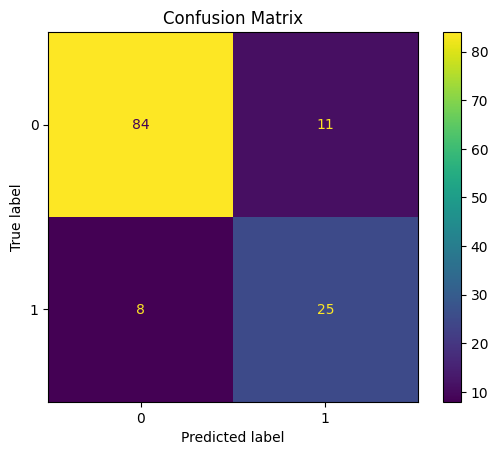

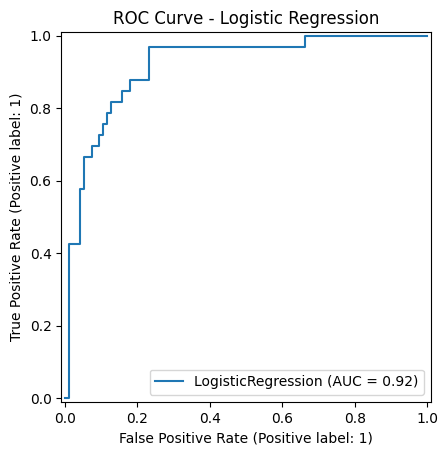

0.8153241650294696
0.8515625
[[0.49597009 0.00297873 0.14457655]]


In [8]:
# 6) Evaluate

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# plot the Confusion Matrix and ROC Curve
cm = confusion_matrix(y_test, y_pred_test)
cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
cmdisp.plot(values_format='d')
plt.title("Confusion Matrix")
plt.show()

RocCurveDisplay.from_estimator(lr, X_test, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()

print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))
print(lr.coef_)


In [9]:
from io import StringIO

# 1) Put your new transactions into a multi-line string
new_transactions_str = """2025-03-19,2025-03-19,1234,Netflix,Subscription,15.99,0.0
2025-03-20,2025-03-20,5555,Uber,Transportation,8.45,0.0
2025-03-20,2025-03-21,7777,Amazon Purchase,Merchandise,159.99,0.0
2025-03-21,2025-03-21,9000,PayPal Transfer,Transfer,0.0,150.0
2025-03-22,2025-03-22,4321,Local Grocery,Groceries,35.50,0.0
"""

# 2) Read it into a DataFrame with the proper column names
columns = [
    "Transaction Date",
    "Posted Date",
    "Card No.",
    "Description",
    "Category",
    "Debit",
    "Credit"
]
df_new = pd.read_csv(StringIO(new_transactions_str), names=columns)

In [10]:
# Convert date columns to datetime
df_new["Transaction Date"] = pd.to_datetime(df_new["Transaction Date"])
df_new["Posted Date"] = pd.to_datetime(df_new["Posted Date"])

# Extract numeric features from "Transaction Date"
df_new["year"] = df_new["Transaction Date"].dt.year
df_new["month"] = df_new["Transaction Date"].dt.month
df_new["day"] = df_new["Transaction Date"].dt.day
df_new["day_of_week"] = df_new["Transaction Date"].dt.dayofweek

# Drop the original date columns
df_new.drop(columns=["Transaction Date", "Posted Date"], inplace=True)

# Fill missing values in 'Debit' and 'Credit' if necessary
df_new["Debit"] = df_new["Debit"].fillna(0)
df_new["Credit"] = df_new["Credit"].fillna(0)

# One-hot encode 'Description' and 'Category'
df_new = pd.get_dummies(df_new, drop_first=True)

In [11]:
# Align columns to match X.columns from training
df_new = df_new.reindex(columns=X.columns, fill_value=0)

# Scale the new data using the SAME scaler used on X_train
df_new_scaled = scaler.transform(df_new)

# Predict using your trained logistic regression model (lr)
pred_labels = lr.predict(df_new_scaled)
pred_probs = lr.predict_proba(df_new_scaled)

print("\n=== Predictions ===")
for i, (label, probs) in enumerate(zip(pred_labels, pred_probs)):
    print(f"Row {i}: Fraud Label={label}, Probabilities=[Not Fraud={probs[0]:.3f}, Fraud={probs[1]:.3f}]")

# Format the predictions into a DataFrame similar to the original df



print(predictions_df)

NameError: name 'scaler' is not defined